<Body>   
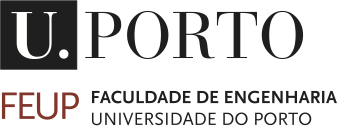   
<h1> <b>Analysis of Complex Data </b> </h1>
</Body>  

<br>**Master in Data Science & Engineering**     <br><br> **Henrique Ribeiro - Ian Karkles - Vitor Pereira**  <br>
<br> Faculty of Engineering, University of Porto <br>FEUP Sep. 2023 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functions import *
import missingno
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import random
from faker import Faker


In [5]:
pd.__version__

'1.5.3'

In [ ]:
!pip install pandas==1.5.3

In [6]:
## Downgrade Matplotlib to avoid error
import matplotlib
matplotlib.__version__


'3.6.3'

In [36]:
business = pd.read_csv('dataset/greenwood_business.csv')
reviews = pd.read_csv('dataset/greenwood_reviews.csv')
user = pd.read_csv('dataset/greenwood_user.csv')
# Remove Unnamed colunm
business = business.loc[:, ~business.columns.str.contains('^Unnamed')]
reviews = reviews.loc[:, ~reviews.columns.str.contains('^Unnamed')]
reviews = reviews.drop(columns='city', axis=1)
user = user.loc[:, ~user.columns.str.contains('^Unnamed')]

# Data Understanding

## Business

In [3]:
missing_values_table(business, 'Business')


The Business dataframe has 649 rows and 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
hours,100,15.4
attributes,56,8.6
address,15,2.3


<AxesSubplot: >

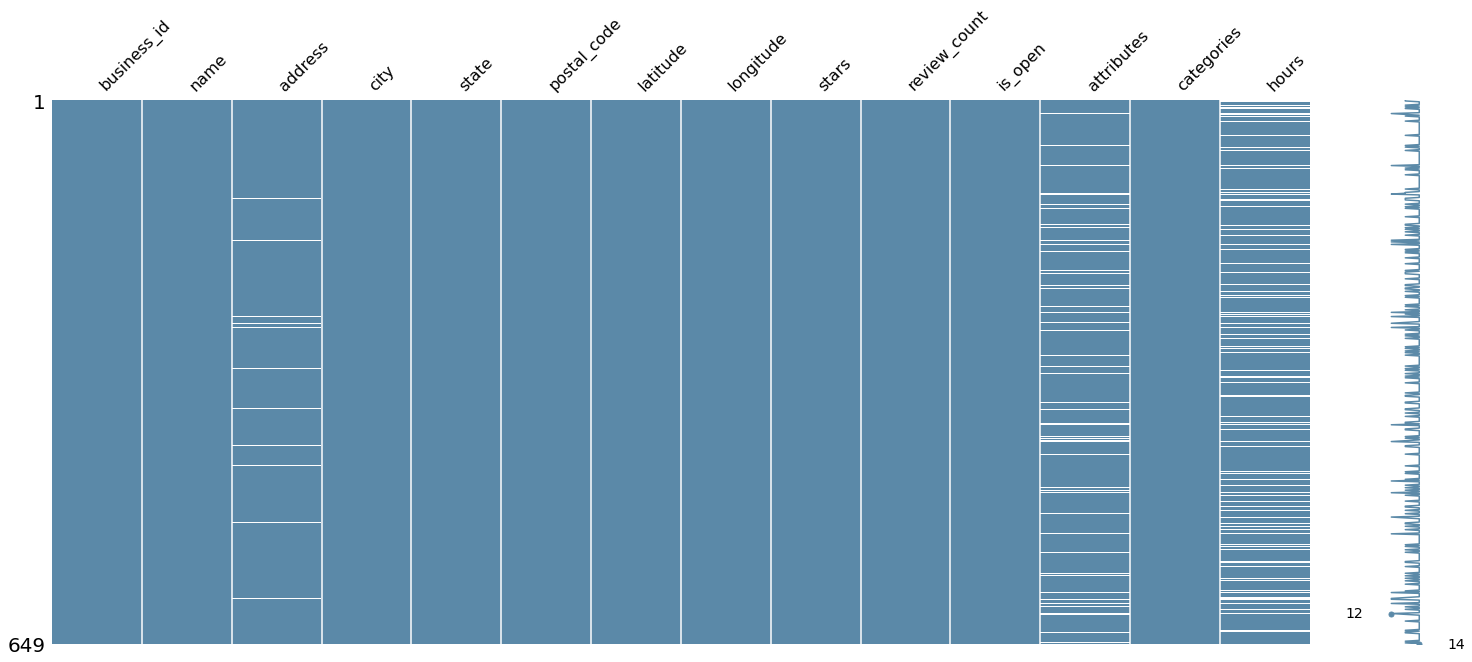

In [8]:
missingno.matrix(business, color=(0.36, 0.54, 0.66))

In [9]:
#print number of distinct values for each column
for col in business.columns:
    print(f'Uniques values in {col}: {len(business[col].unique())}')

Uniques values in business_id: 649
Uniques values in name: 604
Uniques values in address: 561
Uniques values in city: 1
Uniques values in state: 1
Uniques values in postal_code: 7
Uniques values in latitude: 593
Uniques values in longitude: 587
Uniques values in stars: 9
Uniques values in review_count: 104
Uniques values in is_open: 2
Uniques values in attributes: 501
Uniques values in categories: 578
Uniques values in hours: 465


In [10]:
#top 10 categories with most businesses
business['categories'].value_counts().head(10)

Nail Salons, Beauty & Spas     8
Pizza, Restaurants             7
Restaurants, Pizza             5
Restaurants, Mexican           5
Beauty & Spas, Nail Salons     5
Food, Coffee & Tea             4
Chinese, Restaurants           4
Grocery, Food                  3
Hotels & Travel, Car Rental    3
Beauty & Spas, Barbers         3
Name: categories, dtype: int64

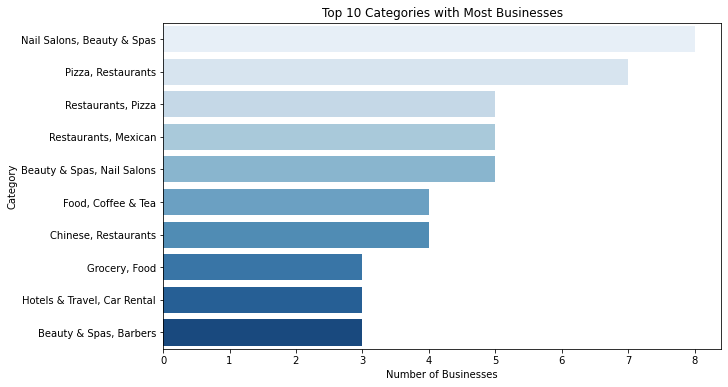

In [28]:
# Create a custom blue color palette
blue_palette = sns.color_palette("Blues",10)

plt.figure(figsize=(10, 6))
sns.countplot(y='categories', data=business, order=business['categories'].value_counts().iloc[:10].index, palette=blue_palette)
plt.title('Top 10 Categories with Most Businesses')
plt.xlabel('Number of Businesses')
plt.ylabel('Category')

# Show the plot
plt.show()

In [13]:
#print business categories with the highest average rating where review_count is above 25
business[business['review_count'] > 25].groupby('categories')['stars'].mean().sort_values(ascending=False).head(10)

categories
Bridal, Shopping                                                                                                                  5.0
Ice Cream & Frozen Yogurt, Specialty Food, Candy Stores, Food                                                                     4.5
Eyelash Service, Hair Removal, Beauty & Spas, Waxing, Skin Care                                                                   4.5
Eyebrow Services, Waxing, Hair Removal, Beauty & Spas, Threading Services, Day Spas, Eyelash Service                              4.5
Event Planning & Services, Venues & Event Spaces, Restaurants, Food, Party & Event Planning, American (Traditional), Tea Rooms    4.5
Food, Breweries                                                                                                                   4.5
Food, Desserts, Ice Cream & Frozen Yogurt, Juice Bars & Smoothies                                                                 4.5
Food, Local Flavor, Coffee & Tea                   

In [29]:
#top 10 businesses with higher review count
business[['name','stars' ,'review_count']].sort_values(by='review_count', ascending=False).head(10)

,name,stars,review_count
338,Revery,4.5,389
214,The Cheesecake Factory,3.5,280
391,Jockamo Upper Crust Pizza,4.5,279
466,Oaken Barrel Brewing Company,4.0,272
145,BJ's Restaurant & Brewhouse,3.5,267
520,Main Street Grille,4.0,223
319,Tried & True Alehouse,4.0,201
165,Sisters Korean Restaurant,4.0,194
252,Hops & Fire Craft Tap House,3.5,168
426,Yats,4.0,166


In [15]:
#print top 10 business with 5 stars that have the highest review_count

business[business['stars'] == 5][['name','stars' ,'review_count']].sort_values(by='review_count', ascending=False).head(10)

,name,stars,review_count
272,Bridal Rack,5.0,28
579,McGee Jewelers,5.0,24
394,Urban Euphoria,5.0,21
288,Storm Chiropractic Clinic,5.0,15
401,Emmanuel Church - Greenwood,5.0,13
181,Greenwood Community Center,5.0,13
379,Autobahn Service Center,5.0,12
1,City Center Park,5.0,12
138,Greenwood Public Library,5.0,12
125,Gutty’s Comedy Club - Indiana,5.0,10


In [16]:
#print top 10 business with 4.5 stars that have the highest review_count

business[business['stars'] == 4.5][['name','stars' ,'review_count']].sort_values(by='review_count', ascending=False).head(10)

,name,stars,review_count
338,Revery,4.5,389
391,Jockamo Upper Crust Pizza,4.5,279
243,Mrs Curl Ice Cream,4.5,156
417,Rise 'n Roll Bakery,4.5,142
380,Yokohama,4.5,128
74,GreenGinger,4.5,124
400,Strange Brew,4.5,120
325,Brickhouse Coffee,4.5,114
461,House of Thai,4.5,97
580,Don Cuervo,4.5,90


<AxesSubplot: xlabel='stars', ylabel='review_count'>

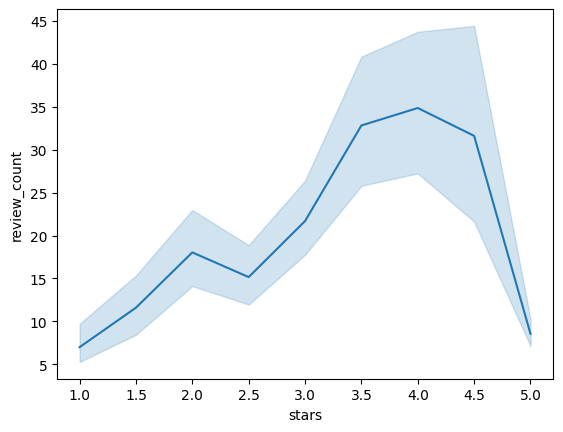

In [17]:
#line plot to see review_count distribution by stars
sns.lineplot(x='stars', y='review_count', data=business)

### Outlier Detection

<AxesSubplot: >

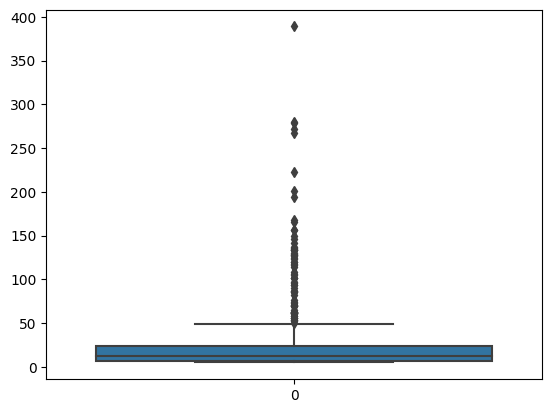

In [18]:
#check outliers in the review_count column
sns.boxplot(business['review_count'])

In [19]:
#print the number of outliers above the third quartile
q3 = business['review_count'].quantile(0.75)

#number of values above the third quartile
print('Number of outliers above the third quartile: ', business[business['review_count'] > q3 + 1.5 * (q3 - business['review_count'].quantile(0.25))].shape[0])

#number of values that are not outliers
print('Number of values that are not outliers: ', business[business['review_count'] <= q3 + 1.5 * (q3 - business['review_count'].quantile(0.25))].shape[0])

Number of outliers above the third quartile:  77
Number of values that are not outliers:  572


## Reviews

In [32]:
reviews['date'] = pd.to_datetime(reviews['date'])

reviews['year'] = reviews['date'].dt.year
reviews['decade'] = (reviews['date'].dt.year // 10) * 10
reviews_per_year = reviews.groupby('year')['review_id'].count().reset_index()
reviews_per_decade = reviews.groupby('decade')['review_id'].count().reset_index()

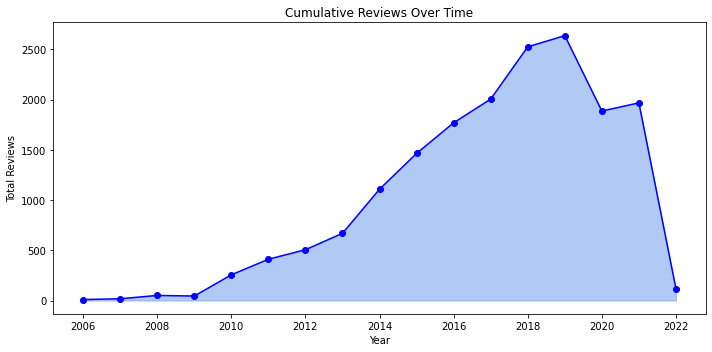

In [41]:
plt.figure(figsize=(10, 5))
plt.fill_between(reviews_per_year['year'], reviews_per_year['review_id'], color='cornflowerblue', alpha=0.5)
plt.plot(reviews_per_year['year'], reviews_per_year['review_id'], marker='o', linestyle='-', color='blue')
plt.xlabel('Year')
plt.ylabel('Total Reviews')
plt.title('Cumulative Reviews Over Time')
#plt.grid(True)
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
reviews_per_year

,year,review_id
0,2006,10
1,2007,18
2,2008,51
3,2009,45
4,2010,256
5,2011,411
6,2012,506
7,2013,669
8,2014,1108
9,2015,1464


<AxesSubplot: >

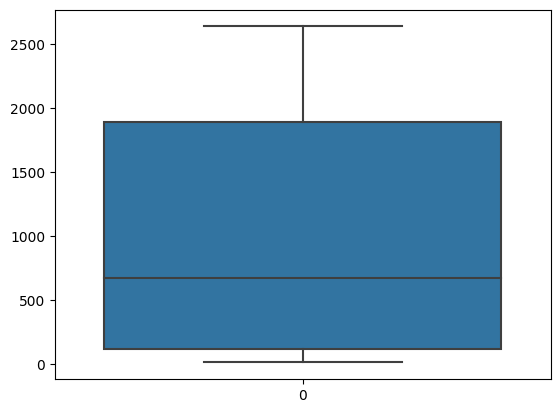

In [23]:
sns.boxplot(reviews_per_year['review_id'])

In [24]:
print(f"There are reviews from {reviews['date'].min()} until {reviews['date'].max()}")

There are reviews from 2006-05-06 19:59:59 until 2022-01-19 04:04:49


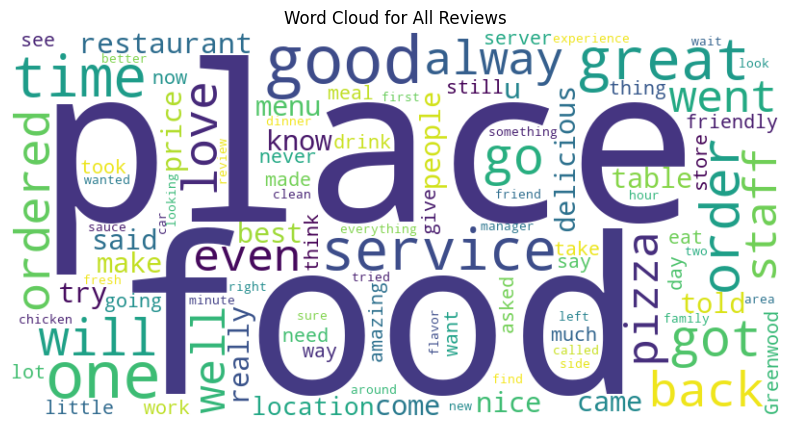

In [25]:
combined_text = ' '.join(reviews['text'])

wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=100,
    stopwords=None
)

wordcloud.generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Reviews')
plt.axis("off")
plt.show()

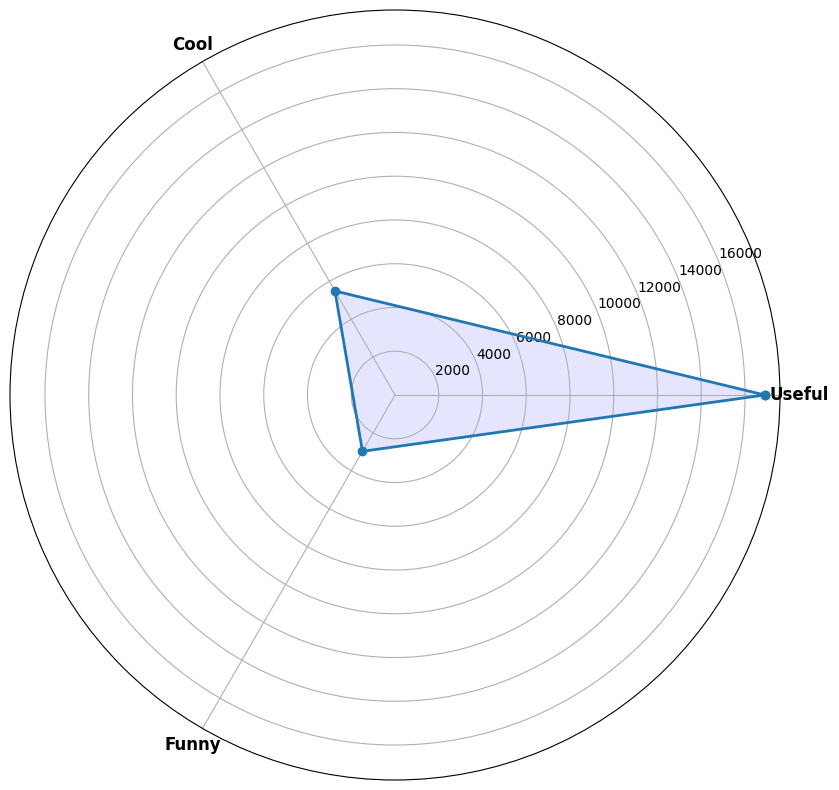

In [26]:
reviews['total_votes'] = reviews['useful'] + reviews['cool'] + reviews['funny']

# Normalize the sums to create a radar plot
max_total_votes = reviews['total_votes'].max()
reviews['normalized_votes'] = reviews['total_votes'] / max_total_votes

# Create a list of categories
categories = ['Useful', 'Cool', 'Funny']

# Calculate the number of categories
num_categories = len(categories)

# Create a list of values for each category
values = reviews.loc[:, ['useful', 'cool', 'funny']].sum().values.flatten().tolist()
values += values[:1]  # To close the radar plot

# Create an array of angles
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
angles += angles[:1]  # To close the radar plot

# Specify custom angles for the ticks
custom_angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Create a radar plot
plt.figure(figsize=(15, 10))
plt.polar(angles, values, marker='o', linestyle='-', linewidth=2)

# Fill the area under the radar plot
plt.fill(angles, values, 'b', alpha=0.1)

# Add category labels with customization
plt.xticks(custom_angles, categories, fontsize=12, fontweight='bold')  # Adjust fontsize and fontweight as needed

# Show the radar plot
plt.show()

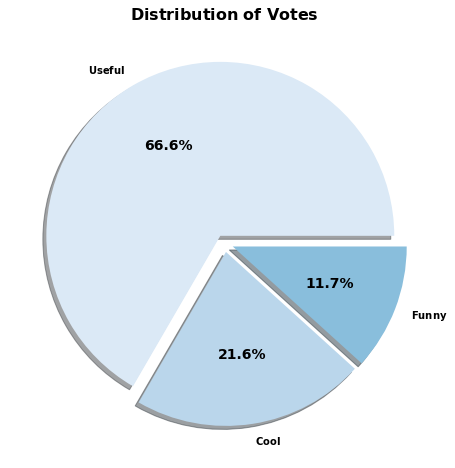

In [49]:
# Create a figure with a white background
fig = plt.figure(figsize=(8, 8), facecolor='white')

# Calculate the sum of votes for each category
sum_useful = reviews['useful'].sum()
sum_cool = reviews['cool'].sum()
sum_funny = reviews['funny'].sum()
sums = [sum_useful, sum_cool, sum_funny]
labels = [r'$\bf{Useful}$', r'$\bf{Cool}$', r'$\bf{Funny}$']
explode = (0.05, 0.05, 0.05)

# Create a custom blue color palette
blue_palette = sns.color_palette("Blues")

# Create a pie chart with the blue palette
_, _, autotexts = plt.pie(sums, labels=labels, autopct='%1.1f%%', startangle=0, explode=explode, shadow=True, colors=blue_palette)
plt.title(r'$\bf{Distribution\ of\ Votes}$', fontsize=16, fontweight='bold')

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

plt.show()

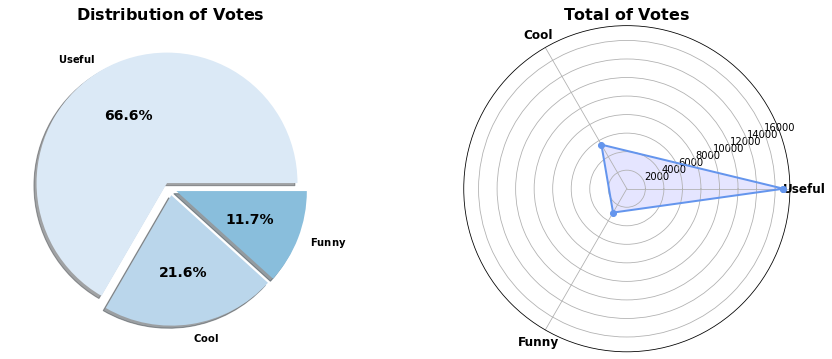

In [46]:
# Create a figure with a white background
fig = plt.figure(figsize=(15, 6), facecolor='white')
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])  # Equal width ratios for both subplots

# Pie Chart
ax1 = fig.add_subplot(gs[0])

# Calculate the sum of votes for each category
sum_useful = reviews['useful'].sum()
sum_cool = reviews['cool'].sum()
sum_funny = reviews['funny'].sum()
sums = [sum_useful, sum_cool, sum_funny]
labels = [r'$\bf{Useful}$', r'$\bf{Cool}$', r'$\bf{Funny}$']
explode = (0.05, 0.05, 0.05)

# Create a blue color palette
blue_palette = sns.color_palette("Blues")

# Create a pie chart with the blue palette
_, _, autotexts = ax1.pie(sums, labels=labels, autopct='%1.1f%%', startangle=0, explode=explode, shadow=True, colors=blue_palette)
ax1.set_title(r'$\bf{Distribution\ of\ Votes}$', fontsize=16, fontweight='bold')

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

# Radar Plot
ax2 = fig.add_subplot(gs[1], polar=True)

# Calculate the sum of votes for each category for each review
reviews['total_votes'] = reviews['useful'] + reviews['cool'] + reviews['funny']
max_total_votes = reviews['total_votes'].max()
reviews['normalized_votes'] = reviews['total_votes'] / max_total_votes
categories = ['Useful', 'Cool', 'Funny']
num_categories = len(categories)
values = reviews.loc[:, ['useful', 'cool', 'funny']].sum().values.flatten().tolist()
values += values[:1]
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
angles += angles[:1]
custom_angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Create a radar plot
ax2.plot(angles, values, marker='o', linestyle='-', linewidth=2, color='cornflowerblue')
ax2.fill(angles, values, 'b', alpha=0.1)

# Add category labels with customization
ax2.set_xticks(custom_angles)
ax2.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax2.set_title(r'$\bf{Total\ of\ Votes}$', fontsize=16, fontweight='bold')

# Show the figure with both subplots
plt.show()

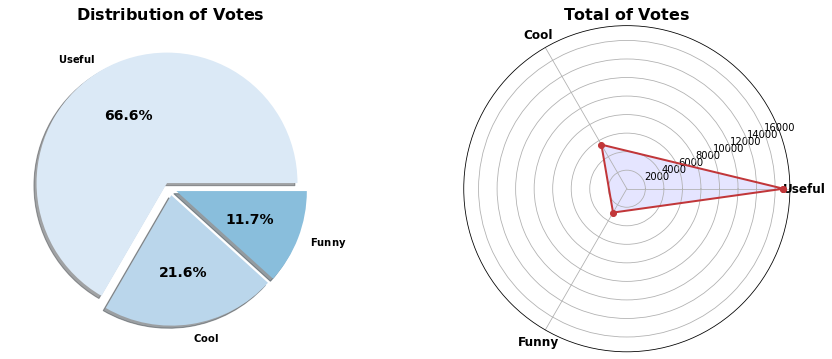

In [42]:
# Create a figure with a white background
fig = plt.figure(figsize=(15, 6), facecolor='white')
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])  # Equal width ratios for both subplots

# Pie Chart
ax1 = fig.add_subplot(gs[0])

# Calculate the sum of votes for each category
sum_useful = reviews['useful'].sum()
sum_cool = reviews['cool'].sum()
sum_funny = reviews['funny'].sum()
sums = [sum_useful, sum_cool, sum_funny]
labels = [r'$\bf{Useful}$', r'$\bf{Cool}$', r'$\bf{Funny}$']
explode = (0.05, 0.05, 0.05)

# Create a blue color palette
blue_palette = sns.color_palette("Blues")

# Create a pie chart with the blue palette
_, _, autotexts = ax1.pie(sums, labels=labels, autopct='%1.1f%%', startangle=0, explode=explode, shadow=True, colors=blue_palette)
ax1.set_title(r'$\bf{Distribution\ of\ Votes}$', fontsize=16, fontweight='bold')

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

# Radar Plot
ax2 = fig.add_subplot(gs[1], polar=True)

# Calculate the sum of votes for each category for each review
reviews['total_votes'] = reviews['useful'] + reviews['cool'] + reviews['funny']
max_total_votes = reviews['total_votes'].max()
reviews['normalized_votes'] = reviews['total_votes'] / max_total_votes
categories = ['Useful', 'Cool', 'Funny']
num_categories = len(categories)
values = reviews.loc[:, ['useful', 'cool', 'funny']].sum().values.flatten().tolist()
values += values[:1]
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
angles += angles[:1]
custom_angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Create a radar plot
ax2.plot(angles, values, marker='o', linestyle='-', linewidth=2)
ax2.fill(angles, values, 'b', alpha=0.1)

# Add category labels with customization
ax2.set_xticks(custom_angles)
ax2.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax2.set_title(r'$\bf{Total\ of\ Votes}$', fontsize=16, fontweight='bold')

# Show the figure with both subplots
plt.show()

In [29]:
missing_values_table(reviews, 'Reviews')

The Reviews dataframe has 17443 rows and 13 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


<AxesSubplot: >

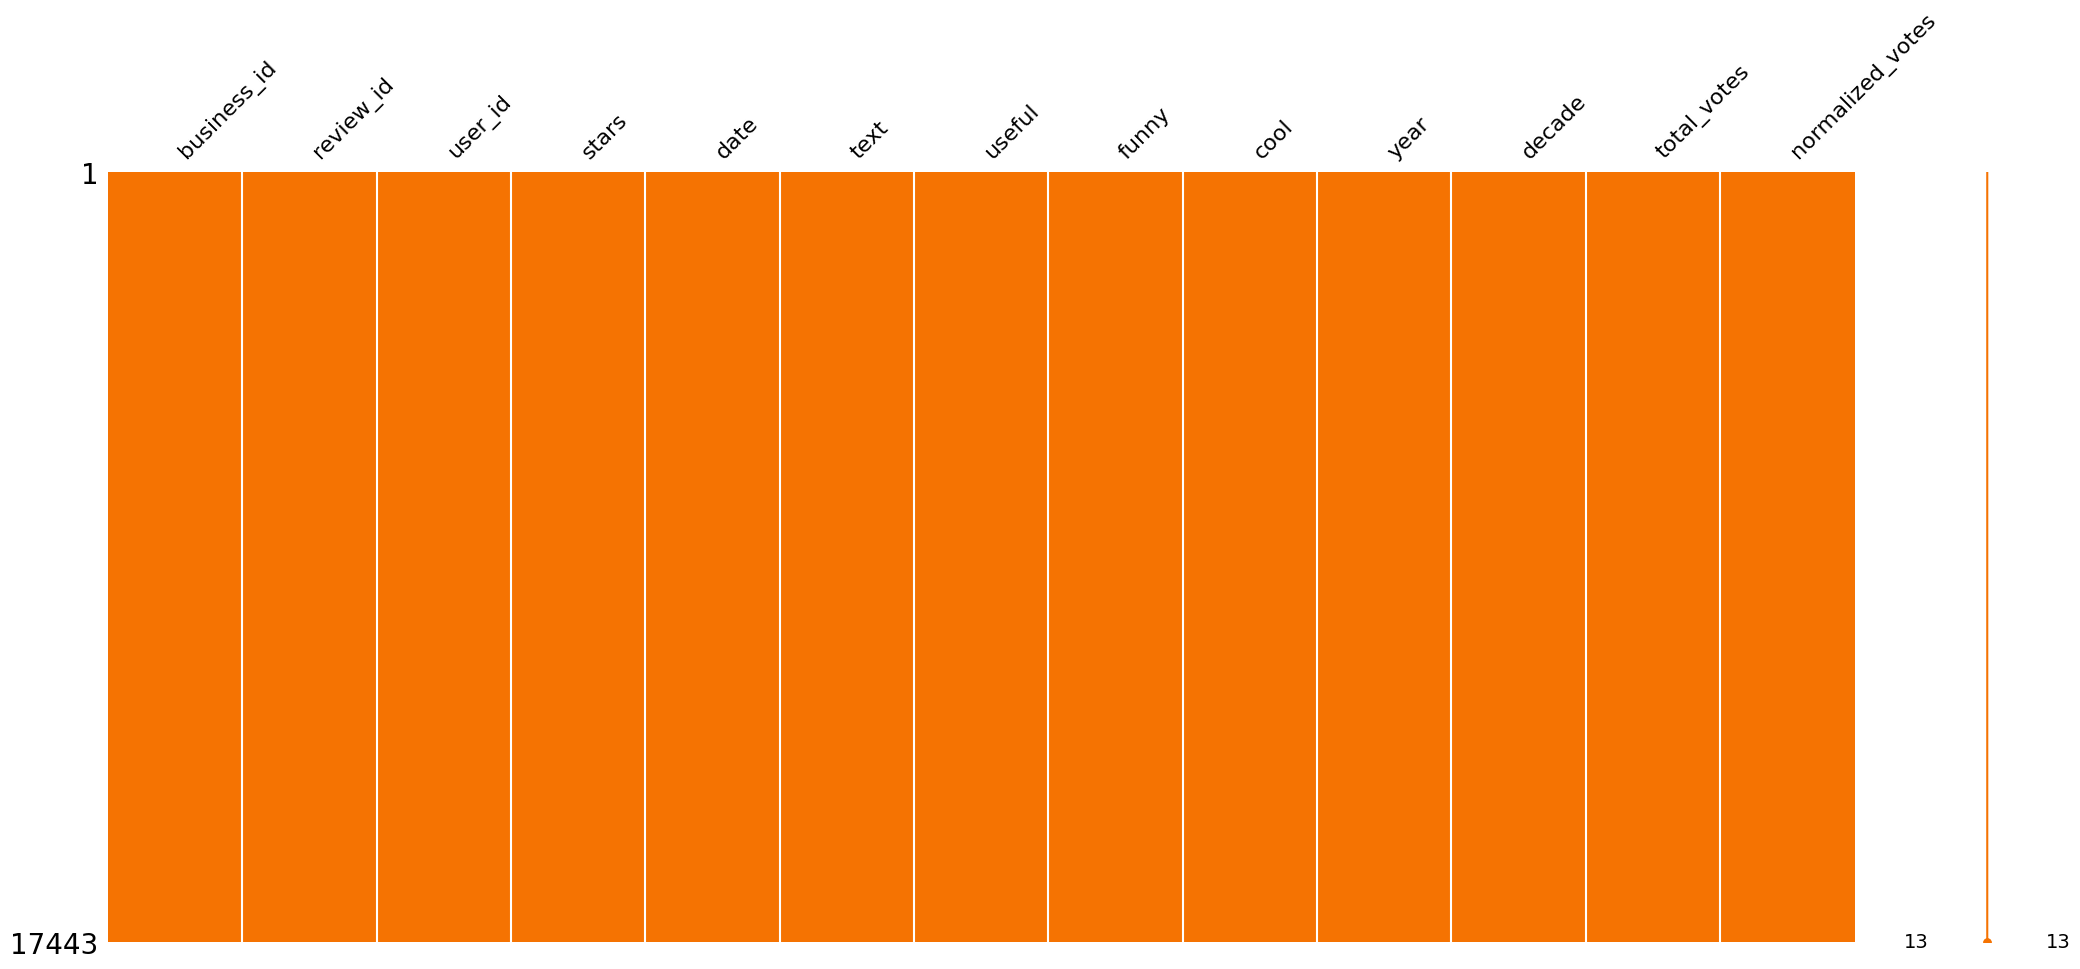

In [30]:
missingno.matrix(reviews, color=(0.961, 0.451, 0.008))

<AxesSubplot: >

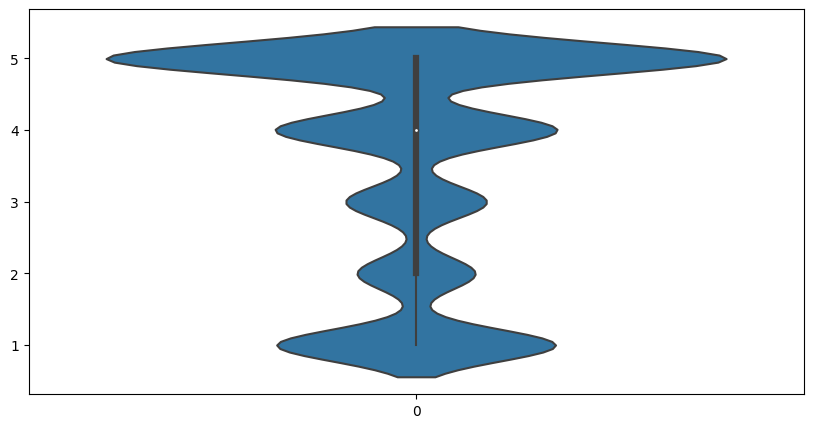

In [31]:
fig,ax = plt.subplots(figsize=(10,5))
sns.violinplot(reviews['stars'])

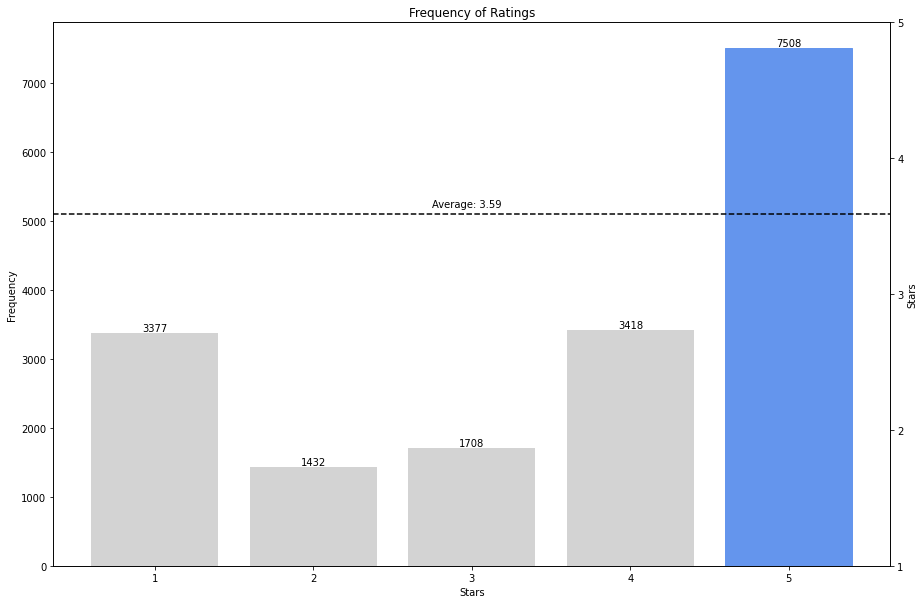

In [50]:
# Calculate the frequency of each value in the 'stars' column
value_counts = reviews['stars'].value_counts().reset_index()
value_counts.columns = ['stars', 'frequency']
fig,ax = plt.subplots(figsize=(15,10))

# Create a countplot to show the frequency
bars = ax.bar(height='frequency', x='stars', data=value_counts, color='lightgray')
bars[0].set_color('cornflowerblue')

# Create twin axes for the rating average
ax2=ax.twinx()
y_coordinate = reviews['stars'].mean()
formatted_y_coordinate = '{:.2f}'.format(y_coordinate)
ax2.axhline(y=y_coordinate, color='black', linestyle='--', label='Average: {}'.format(formatted_y_coordinate))
plt.text(2.75, y_coordinate + 0.05, f'Average: {formatted_y_coordinate}', color='black')
stars = [1, 2, 3, 4, 5]
ax2.set_yticks(stars)

# Set labels
plt.title('Frequency of Ratings')
ax2.set_ylabel('Stars')
ax.set_ylabel('Frequency')
ax.set_xlabel('Stars') 

# Annotate each bar with its respective value
for index, row in value_counts.iterrows():
    ax.text(row['stars'], row['frequency'], str(row['frequency']), ha='center', va='bottom')


# Show the plot
plt.show()


## User

In [33]:
display(user.head(5))
display(user.columns)

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,X8TDMfrauatr4PBIcjfIHQ,Stephanie,316,2011-01-27 19:34:44,"gsu-DpmA7beaDcKy_UDkpw, HQjCR0M8lRFCfdbdHXcSQA...",322,43,113,14,"2013,2014,2015,2017,2018,2019,20,20,2021",...,4,2,0,0,21,9,17,17,9,2
1,eVVy0FU3t-mMYW5PnsbU5w,Robert,22,2012-10-26 01:40:37,"8QKF07ZNMep474sB7-vXdw, 1JtpcHELRrSDoWS80WtzuQ...",8,4,9,0,NaN,...,0,0,0,0,3,2,1,1,1,0
2,4Psac6uj06y_5EPv6CL56g,Randy,362,2011-10-17 02:19:54,"KDewJBJknfWvQyHHFNbfdg, BV3atDWA80Hc23OxENjXsQ...",263,118,74,14,NaN,...,3,0,0,0,9,13,7,7,4,0
3,Nx3cLhGwy8aFAlcHGFg_ag,Rachel,15,2012-07-27 00:13:00,"clk385ygJaFUtRIT2M7yTw, AHRrG3T1gJpHvtpZ-K0G_g...",29,4,6,1,NaN,...,1,0,0,0,0,2,1,1,1,0
4,6S6dvBFEWa4hL7evxHNWHg,Justin,31,2013-02-27 16:05:49,"b3v8udANMGfHhsJ4nxF3Tg, xsQyTGdGwM8k3Ns3miYgGQ...",35,4,7,1,NaN,...,0,0,0,0,0,1,1,1,3,0


Index(['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'useful',
       'funny', 'cool', 'fans', 'elite', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [34]:
user.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000
mean,40.092274,75.270679,19.979520,44.124701,2.662419,3.568365,1.854705,0.366822,0.141427,0.056320,0.043122,3.259415,5.862555,3.673569,3.673569,1.784958,1.242007
std,131.808027,748.454941,253.691765,620.196961,31.439644,1.148539,15.229198,2.636863,1.739891,0.720428,0.808794,26.233837,151.196088,33.141722,33.141722,12.979035,20.523769
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.000000,0.000000,1.000000,0.000000,3.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,25.000000,18.000000,3.000000,5.000000,1.000000,4.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,3986.000000,35764.000000,13661.000000,31816.000000,2086.000000,5.000000,663.000000,115.000000,98.000000,34.000000,47.000000,1651.000000,11869.000000,1613.000000,1613.000000,611.000000,1027.000000


In [35]:
# What are the most common names, and how many users have them?
user['name'].value_counts().head(10)

Chris       94
John        85
Jessica     68
Jennifer    65
Michael     62
Sarah       61
David       59
Ashley      57
Jason       54
Mike        54
Name: name, dtype: int64

In [36]:
# What the average number of reviews per user?
user['review_count'].mean()

40.09227443395153

(array([7.207e+03, 6.210e+02, 2.710e+02, 1.970e+02, 1.130e+02, 9.600e+01,
        4.500e+01, 3.600e+01, 3.700e+01, 2.700e+01, 2.000e+01, 1.500e+01,
        1.600e+01, 1.500e+01, 8.000e+00, 1.000e+01, 8.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

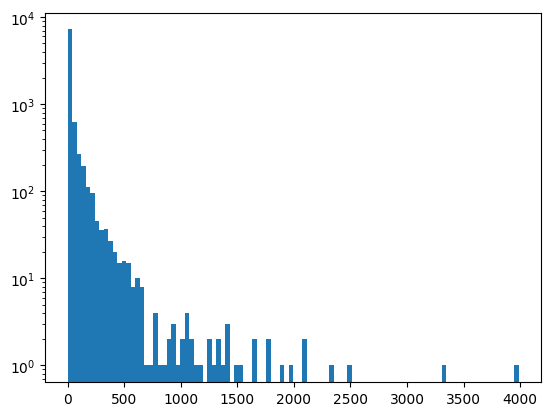

In [37]:
# What is the distribution of the number of reviews per user?
plt.hist(user['review_count'],bins=100,log=True)


In [38]:
# Due to this graph, what are the users with more reviews?
user[user['review_count'] > 1500].sort_values(by='review_count', ascending=False)

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
19,wXdbkFZsfDR7utJvbWElyA,Ken,3986,2016-06-02 17:30:14,"FdIiFCp5vPcFyWGn6_qf-Q, 3BoVJJRVBgfqKIbPI3IdzA...",11836,842,6960,250,"2016,2017,2018,2019,20,20,2021",...,8,6,1,1,157,575,188,188,149,116
306,PlkcpVx74F5bcjTznVoTEg,Jeremy,3309,2016-12-30 21:18:48,"DD5OHbN2dqTFu_7YOykP-Q, 417svAEVHreK6c3SK4M8Tw...",35764,8280,31816,95,"2017,2018,2019,20,20,2021",...,13,10,0,0,414,320,329,329,61,1006
460,AHRrG3T1gJpHvtpZ-K0G_g,Brittany,2492,2011-04-25 17:28:05,"nvHLV4qbwvbKHSCP37xT-w, CQ1J7Z2Irj6c19bwi9GhPg...",18899,6267,13425,2086,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,...",...,115,36,23,20,1651,6794,1613,1613,439,582
6171,KFiz7nL-lRFF-xIgOPZLkg,Richard,2314,2011-01-03 15:41:48,"6481ECASNBPi1R7MR4Oouw, 8qUQrDtH4X0h5zLHpR8uOw...",11197,3948,9177,127,"2011,2012,2013,2014,2015,2016,2017,2018,2019,2...",...,12,9,6,1,197,1036,495,495,71,578
8491,GaWT2KIjIxfIBMgGIm7HGw,Ashley,2101,2015-06-13 20:23:17,"XTkuInJdNwHbuw_TJNW7lw, laVDAAn4LPmyGWe381H6Cw...",33475,7724,30421,269,"2019,20,20,2021",...,24,11,3,0,447,889,812,812,112,1027
3801,1qW4Z75nLsanAKHUSPsYrw,Howard,2079,2016-01-10 19:46:21,"e5iEuA8Juic7N-hnYIMTmg, fbDygUOP3JEaVzBqTpipcg...",2266,556,763,29,"2016,2017,2018,2019,20,20,2021",...,2,1,0,1,33,19,15,15,21,2
75,ivW0Vad81qJ8SIgqJ8p1Mw,Melissa,1970,2011-10-15 23:23:13,"LOLGcB8sZy0nQ91Q9ESe_w, 5Y5KbsI5buMcNh2hTFaRpA...",12294,4607,10233,172,"2013,2014,2017,2018,2019,20,20,2021",...,17,14,3,0,126,129,176,176,62,100
7394,d7D4dYzF6THtOx9imf-wPw,Regina,1912,2008-12-05 07:16:22,"vJwSzy0-9pF8QT1EAS2ZFA, 5F_ASUSCHFf3YotkKioZ5w...",26931,13661,22969,430,"2013,2014,2015,2016,2017,2018,2019,20,20,2021",...,52,44,10,11,597,790,1104,1104,611,618
1215,S2R1D2Igo9RVx3DfS6nwbg,Nobuyuki,1793,2011-11-26 07:45:34,"5uXGa1l0BRTj7Ao_vDHhyg, X5tZ_Z28lQwjJn63RtTxvg...",3431,1018,1946,103,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,...",...,8,5,2,2,342,360,173,173,57,24
2569,k0m5nvgAIIA24t_iPZOAsw,Reed,1781,2008-10-29 11:57:21,"_HM9MgWJ82moeac5MNAKzQ, H5hQMKeIdWMmcrfbtjTWgw...",2795,808,1210,82,"2010,2011,2012,2013,2014,2015,2016,2017,2018,2...",...,10,7,1,7,172,189,127,127,81,5


<AxesSubplot: >

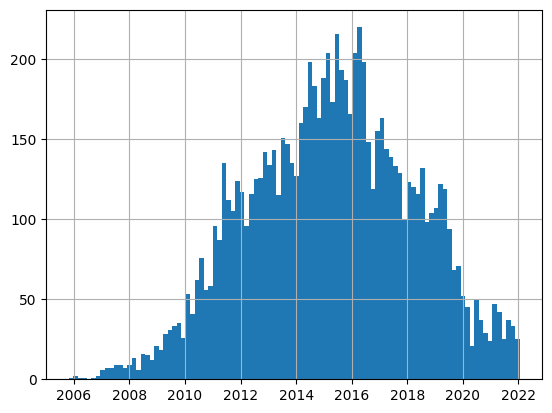

In [39]:
#Whats the distribution of join dates?
user['yelping_since'] = pd.to_datetime(user['yelping_since'])
user['yelping_since'].hist(bins=100)

In [40]:
# Who is the oldest user?
user[user['yelping_since'] == user['yelping_since'].min()]

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
180,CE06U3ug53ocDNICOo2xZw,Sean,166,2005-10-23 21:09:25,"X1zRuJLlxxMfs4re1wWMsQ, DG62eUmnEy4r1aICOc7MoA...",127,23,28,2,"20,20,2021",...,5,0,0,0,6,8,6,6,6,0


In [41]:
# Who is the newest user?
user[user['yelping_since'] == user['yelping_since'].max()]

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
4013,ENRHze7vfMNkas-M688Iwg,Lynn,1,2022-01-16 01:24:22,None,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot: >

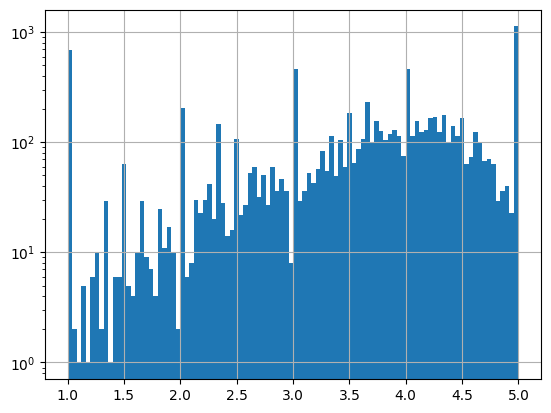

In [42]:
# Distribution of average stars
plt.size=(12,8)
user['average_stars'].hist(bins=100,log=True)


<AxesSubplot: >

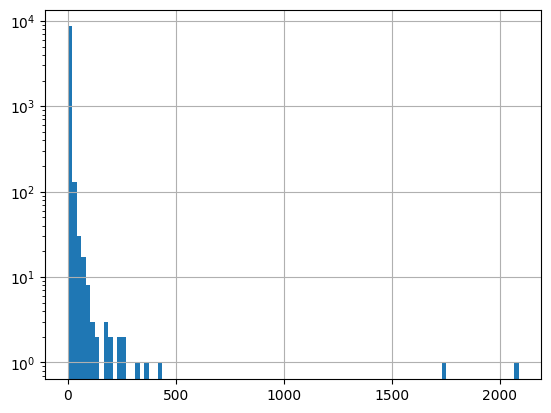

In [43]:
# Distribution of fans
plt.size=(12,8)
user['fans'].hist(bins=100,log=True)

In [44]:
# top 10 users with more fans
user.sort_values(by='fans', ascending=False).head(10)

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
460,AHRrG3T1gJpHvtpZ-K0G_g,Brittany,2492,2011-04-25 17:28:05,"nvHLV4qbwvbKHSCP37xT-w, CQ1J7Z2Irj6c19bwi9GhPg...",18899,6267,13425,2086,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,...",...,115,36,23,20,1651,6794,1613,1613,439,582
5147,WwulXySQN8t2hwqH_yWurA,Niki,1512,2014-12-15 03:33:23,"sYYbJ6gURyTXlmg3Lsy1kw, RImQO5EF2zmPnnGn7c_6Tw...",12130,1789,8456,1746,"2015,2016,2017,2018,2019,20,20,2021",...,56,3,4,1,913,11869,914,914,148,236
7394,d7D4dYzF6THtOx9imf-wPw,Regina,1912,2008-12-05 07:16:22,"vJwSzy0-9pF8QT1EAS2ZFA, 5F_ASUSCHFf3YotkKioZ5w...",26931,13661,22969,430,"2013,2014,2015,2016,2017,2018,2019,20,20,2021",...,52,44,10,11,597,790,1104,1104,611,618
884,KDewJBJknfWvQyHHFNbfdg,Jon,892,2007-11-07 21:12:57,"Ew7xtxeER7DALIlo9R9eaA, ANDNCdvARRxxo1dNDrRX0w...",5482,4192,4346,365,"2010,2011,2012,2013",...,69,66,20,25,556,1688,785,785,345,68
283,0PkCxX5PeubHdkOLnvSVaA,Chad,874,2015-02-27 23:59:34,"tN0lpNS8j9Rpu4ZEZ-KwKQ, ypFjUeQ_W5C1sYO7Js_mbg...",14102,8409,11938,315,"2015,2016,2017,2018,2019,20,20,2021",...,20,44,3,1,211,429,736,736,172,355
8491,GaWT2KIjIxfIBMgGIm7HGw,Ashley,2101,2015-06-13 20:23:17,"XTkuInJdNwHbuw_TJNW7lw, laVDAAn4LPmyGWe381H6Cw...",33475,7724,30421,269,"2019,20,20,2021",...,24,11,3,0,447,889,812,812,112,1027
14,OIDpKC2p61qVO_spPqw1qA,Nicole,1520,2011-11-23 22:47:42,"z2X43Il6_QxLmPaoV7S9AA, XgPyniNycl-LrHHQLdjDQQ...",5461,997,2946,263,"2015,2016,2017,2018,2019,20,20,2021",...,6,5,2,0,99,179,104,104,96,78
19,wXdbkFZsfDR7utJvbWElyA,Ken,3986,2016-06-02 17:30:14,"FdIiFCp5vPcFyWGn6_qf-Q, 3BoVJJRVBgfqKIbPI3IdzA...",11836,842,6960,250,"2016,2017,2018,2019,20,20,2021",...,8,6,1,1,157,575,188,188,149,116
1285,zYFGMy1_thjMnvQLX6JNBw,Wanda,1405,2012-11-15 05:18:16,"dyMOjbCX9JU1F1CVb7fEtA, MzZ2LR4xGF5be7WNPRunCA...",8607,1882,6035,247,"2013,2014,2015,2016,2017,2018,2019,20,20,2021",...,38,11,3,0,246,386,298,298,173,194
2148,A9cXP_K95FRor1qxuUEu2g,Richard,1247,2014-07-19 23:47:39,"qsnVAE7nYhrpiFTaAL8jbg, 7o5HLEkG5UhtniO5RASU_A...",7304,1486,4582,189,"2014,2015,2016,2017,2018,2019,20,20,2021",...,17,3,0,2,194,1233,366,366,220,21


<AxesSubplot: >

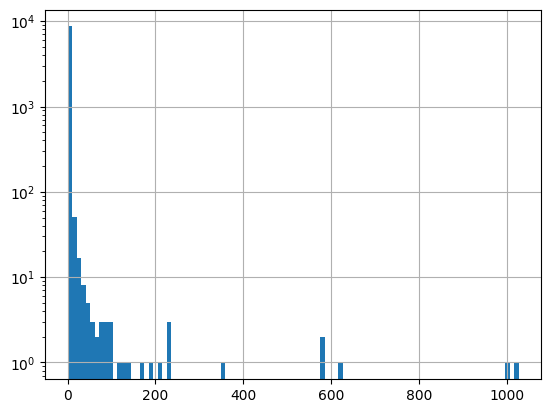

In [45]:
# What about the distribution of compliment_photos?
user['compliment_photos'].hist(bins=100,log=True)


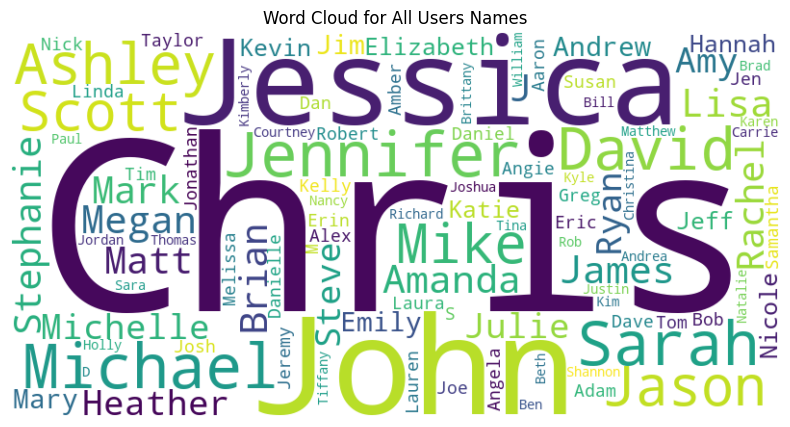

In [46]:
combined_text = ' '.join(user['name'])

wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=100,
    stopwords=None
)

wordcloud.generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Users Names')
plt.axis("off")
plt.show()

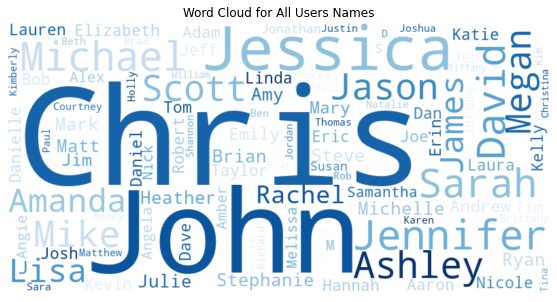

In [52]:
combined_text = ' '.join(user['name'])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    stopwords=None,
    collocations=False,  # Disable collocations to ensure consistent color
    colormap='Blues'      # Set the colormap to 'Blues'
)

wordcloud.generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Users Names')
plt.axis("off")
plt.show()

In [47]:
missing_values_table(user, 'User')

The User dataframe has 8789 rows and 22 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
elite,7687,87.5


<AxesSubplot: >

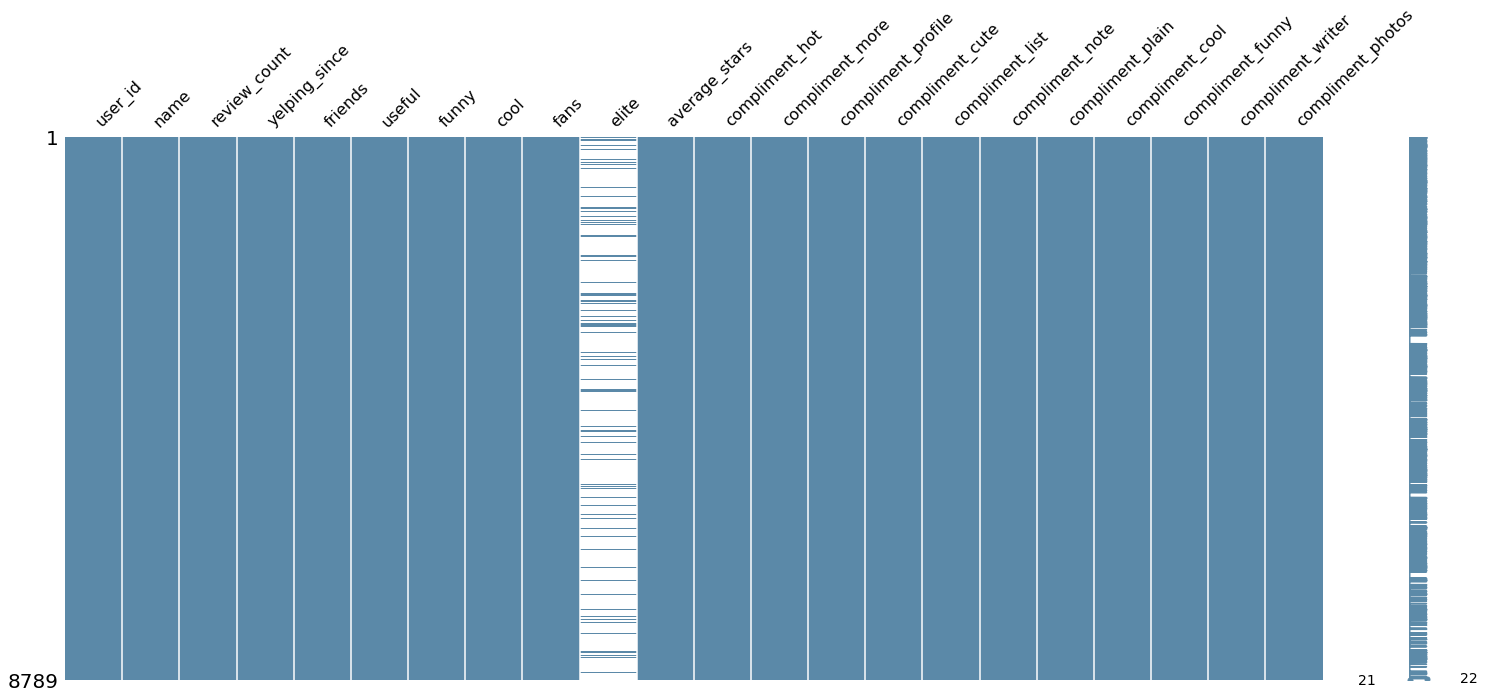

In [51]:
missingno.matrix(user, color=(0.36, 0.54, 0.66))

In [49]:
# what's the differnce between the average user and the elite user?
# Average user
display(user['review_count'].mean().round(2))
# Non Elite user
display(user[user['elite'].isnull()]['review_count'].mean().round(2))
# Elite user
display(user[user['elite'].notnull()]['review_count'].mean().round(2))
# How many users are elite?
display(user['elite'].notnull().sum())
# How many users are not elite?
display(user['elite'].isnull().sum())

40.09

14.46

218.87

1102

7687

/var/folders/d9/6wl161rj2wn6nhd_fn7sclm80000gn/T/ipykernel_29492/2129903104.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = user.corr()


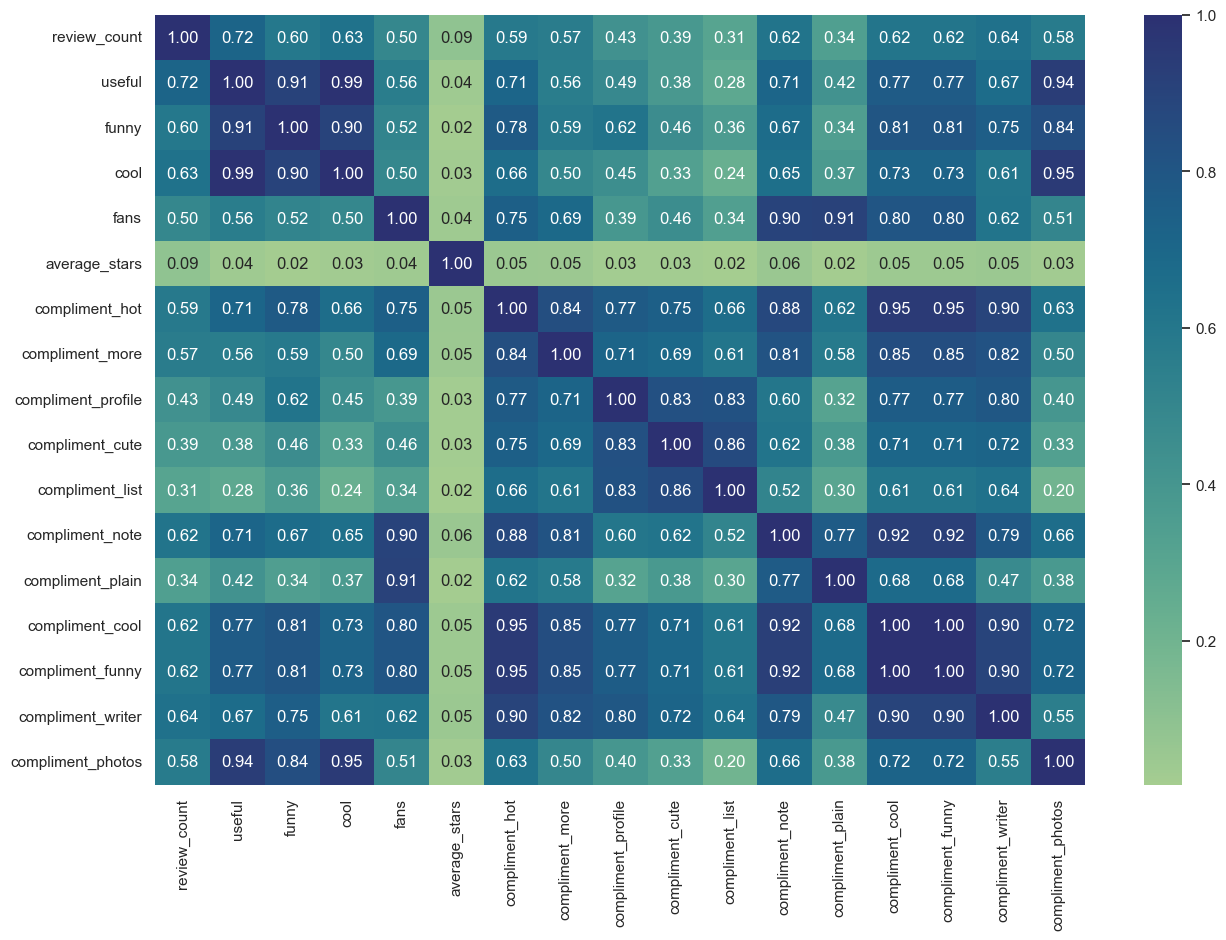

In [50]:
## Correlation between users between fields in user with heatmap
corr = user.corr()
sns.set(rc={'figure.figsize':(15,10)})
plot = sns.heatmap(corr, cmap="crest", annot=True, fmt=".2f")

<AxesSubplot: xlabel='cool', ylabel='useful'>

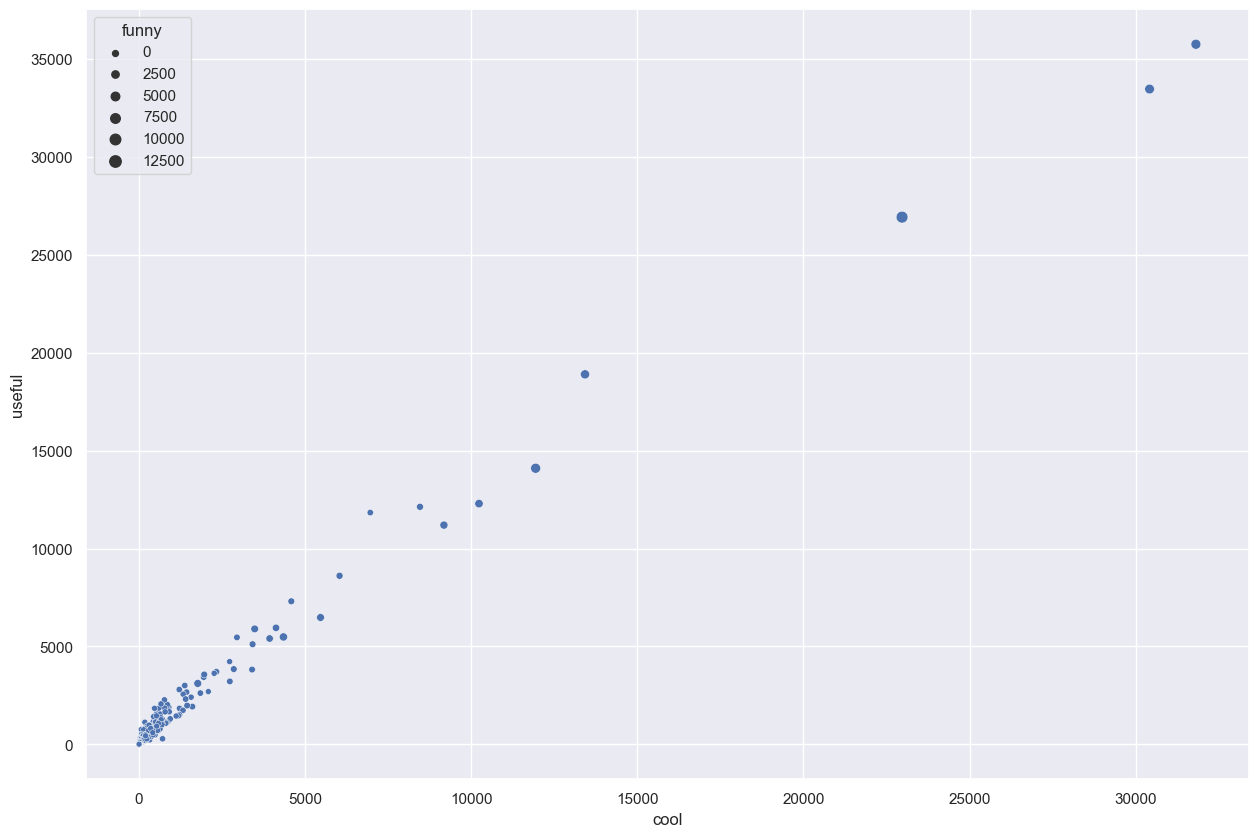

In [51]:
#The correlation between the year, average stars and the rest of the fields is very low.

# How Cool, Funny and Useful are related?
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x='cool', y='useful', size='funny', data=user)
# There is a positive correlation between cool and useful, and a negative correlation between funny and useful.


In [52]:
# Calculate the correlation between cool and useful and funny and useful and funny and cool,
# and see if the scatterplot is correct.
display(user[['cool', 'useful','funny']].corr())
# Very high correlation between cool and useful, and also strong correlation between funny and useful.

,cool,useful,funny
cool,1.000000,0.989339,0.902175
useful,0.989339,1.000000,0.907276
funny,0.902175,0.907276,1.000000


# Data Preparation

## User

### Category Uniformization

In [53]:
# Create a new column for the simplified categories
business['Simplified_Category'] = business['categories']

# Function to find common categories between two strings
def find_common_categories(str1, str2):
    categories1 = set(str1.split(', '))
    categories2 = set(str2.split(', '))
    common_categories = categories1.intersection(categories2)
    return ', '.join(common_categories) if len(common_categories) >= 2 else None

for i in range(len(business)):
    common_categories = None
    
    for j in range(len(business)):
        if i != j:  # Skip comparing a row with itself
            common_categories = find_common_categories(business['Simplified_Category'][i], business['categories'][j])
            
            # If two or more common categories are found, update the Simplified_Category column
            if common_categories is not None and len(common_categories.split(', ')) >= 2:
                business.at[i, 'Simplified_Category'] = common_categories
                break
    
    # If no common categories found or common_categories is None, set it to the original category
    if common_categories is None:
        business.at[i, 'Simplified_Category'] = business['categories'][i]



In [54]:
#print all most common categories
business['Simplified_Category'].value_counts()

Food, Restaurants                                                                  50
Beauty & Spas, Nail Salons                                                         30
Restaurants, Fast Food                                                             30
Auto Repair, Automotive                                                            20
Fashion, Shopping                                                                  20
                                                                                   ..
Shopping, Thrift Stores                                                             1
Flowers & Gifts, Shopping                                                           1
Health & Medical, General Dentistry, Dentists, Oral Surgeons, Cosmetic Dentists     1
Fashion, Accessories, Bridal, Shopping                                              1
Party & Event Planning, Event Planning & Services                                   1
Name: Simplified_Category, Length: 195, dtype: int64

In [55]:
#list the business which categories are 'Pizza, Restaurants' and those that are 'Restaurants, Pizza'
business[business['categories'] == 'Pizza, Restaurants'].head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Simplified_Category
24,ivmKTD7lUjsGU7smNOL81A,"Pizza Twist - Greenwood, IN","997 E County Line Rd, Ste P",Greenwood,IN,46143,39.634986,-86.084865,3.5,46,1,"{'Caters': 'True', 'Ambience': ""{'touristy': N...","Pizza, Restaurants","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...","Restaurants, Pizza"
81,gcTe0m14Aq1jB3yxemtfsQ,Papa John's Pizza,334 S.Emerson Ave,Greenwood,IN,46143,39.612414,-86.083506,2.5,8,1,"{'HasTV': 'True', 'BusinessParking': ""{'garage...","Pizza, Restaurants",NaN,"Restaurants, Pizza"
244,XbsXW_4JspQmpwLsTv7kAQ,Pizza King,284 S State Rd 135,Greenwood,IN,46142,39.611358,-86.159199,3.0,6,0,"{'RestaurantsReservations': 'False', 'Restaura...","Pizza, Restaurants",NaN,"Restaurants, Pizza"


In [56]:
#list the business which categories are 'Pizza, Restaurants' and those that are 'Restaurants, Pizza'
business[business['categories'] == 'Restaurants, Pizza'].head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Simplified_Category
127,RlmNkKx_SMl1tkjt0JcKaA,Papa Murphy's,2150 Independence Dr,Greenwood,IN,46143,39.584556,-86.101210,2.0,6,0,"{'RestaurantsReservations': 'False', 'Caters':...","Restaurants, Pizza",NaN,"Restaurants, Pizza"
225,y_GSgWHAMoyVzR4b09IeIw,AGAPÉ PIZZA,1201 Greenwood Park E Dr,Greenwood,IN,46142,39.633497,-86.116800,4.5,15,0,"{'RestaurantsTakeOut': 'True', 'HasTV': 'False...","Restaurants, Pizza",NaN,"Restaurants, Pizza"
344,EjctrXdmtG4kcBEEnuY4Tw,Pizza King,"520 N State Rd 135, Ste S",Greenwood,IN,46142,39.621060,-86.159789,3.0,15,1,"{'RestaurantsPriceRange2': '2', 'HappyHour': '...","Restaurants, Pizza","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...","Restaurants, Pizza"


### One-Hot Encoding (Elite User)

In [57]:
#one-hot enconding of column elite in the user df

user['elite'] = user['elite'].str.split(',')

#replace the NaN values with string 'a'
user['elite'] = user['elite'].fillna('a')

# Get a list of unique years from all users
unique_years = set()
for years_list in user['elite']:
    unique_years.update(years_list)

# Create binary columns for each unique year
for year in unique_years:
    user[f'elite{year}'] = user['elite'].apply(lambda x: 1 if year in x else 0)

# Drop the original "elite" column
user.drop(columns=['elite'], inplace=True)

#drop the columns elite20, eliteo, eliten, eliteN, elitee
user.drop(columns=['elitea', 'elite20'], inplace=True)

In [53]:
business

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,PYW8Buz8S8LpjIe6mZTAcw,Payless Liquors,954 N State Rd 135,Greenwood,IN,46143,39.632280,-86.158674,3.5,13,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Food, Beer, Wine & Spirits",NaN
1,Ir5Ts-NC7DDTL3XLizhV3g,City Center Park,415 Lincoln St,Greenwood,IN,46142,39.612805,-86.112796,5.0,12,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Playgrounds, Kids Activities, Active Life, Par...",NaN
2,fjvaxQ_-MpCk-e_Hy_9AZA,Board & Brush Greenwood,200 West Main St,Greenwood,IN,46142,39.613819,-86.108813,5.0,6,1,"{'WiFi': ""u'free'""}","Art Classes, Education, Arts & Entertainment","{'Tuesday': '0:0-0:0', 'Wednesday': '0:0-0:0',..."
3,y8GId04Q7slRzgFYq-Yvkg,Tuchman Cleaners,378 Western Blvd,Greenwood,IN,46142,39.619064,-86.211680,1.0,5,1,"{'BikeParking': 'True', 'BusinessParking': ""{'...","Dry Cleaning & Laundry, Laundry Services, Shoe...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-19:0', ..."
4,Z5c5cPbD3iGNMXYVLLA-Cw,Widerange,300 US 31 S,Greenwood,IN,46142,39.612282,-86.115746,2.0,8,1,{'BusinessAcceptsCreditCards': 'True'},"Used Car Dealers, Car Dealers, Car Buyers, Aut...","{'Monday': '10:0-18:30', 'Tuesday': '10:0-17:0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,rlgpNDhdB5LwtOWoB0G2nA,Dave & Buster's,"1251 US Hwy 31N, Ste F01B",Greenwood,IN,46142,39.631905,-86.120290,2.5,22,1,"{'HappyHour': 'True', 'HasTV': 'True', 'Ambien...","Arts & Entertainment, Nightlife, Arcades, Rest...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-23:0', ..."
645,4VJTE8W_KEhtGIWvd26Xvg,Waterman's Farm Market,1100 N New State Rd 37,Greenwood,IN,46142,39.631268,-86.212227,5.0,6,1,"{'RestaurantsPriceRange2': '1', 'BusinessParki...","Fruits & Veggies, Food, Specialty Food",NaN
646,lYdmx6mXhD5jyXXpdjNFRA,Smokey Bones,780 US Highway 31,Greenwood,IN,46142,39.626847,-86.121427,3.0,106,1,"{'BikeParking': 'True', 'BusinessParking': ""{'...","Chicken Wings, Barbeque, Restaurants, American...","{'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', ..."
647,DMYTGaunth3BMi7SmQEdvQ,PetSuites Greenwood,1032 N Emerson Ave,Greenwood,IN,46143,39.631153,-86.085342,4.0,17,1,NaN,"Pet Groomers, Pets, Pet Services, Pet Boarding...","{'Monday': '0:0-0:0', 'Tuesday': '6:30-20:0', ..."


## Business

### Hours

In [58]:
# Create a list of non-null hours
non_null_hours = business['hours'].dropna().tolist()

# Iterate over the DataFrame and fill null values with random non-null hours
for index, row in business.iterrows():
    if pd.isnull(row['hours']):
        random_hours = random.choice(non_null_hours)
        business.at[index, 'hours'] = random_hours

### Attributes

In [59]:
# Create a list of non-null hours
non_null_att = business['attributes'].dropna().tolist()

# Iterate over the DataFrame and fill null values with random non-null hours
for index, row in business.iterrows():
    if pd.isnull(row['attributes']):
        random_att = random.choice(non_null_att)
        business.at[index, 'attributes'] = random_att

### Addresses

In [60]:
fake = Faker('en_US')
column_name = 'address'
null_indices = business[business[column_name].isnull()].index

# Function to generate a fake Greenwood, US address
def generate_greenwood_address():
    # Manually create a Greenwood, US address
    city = "Greenwood"
    state_abbr = "IN"  # Replace with the appropriate state abbreviation if needed
    postal_code = fake.zipcode()  # Use a fake postal code
    return f"{fake.street_address()}"

# Fill null values with Greenwood, US addresses
for index in null_indices:
    business.at[index, column_name] = generate_greenwood_address()




In [61]:
user.to_csv('greenwood_user_final.csv')
business.to_csv('greenwood_business_final.csv')